Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

- [ ] Use a subset of the data where `BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'` and the sale price was more than 100 thousand and less than 2 million.
- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a ridge regression model with multiple features. Use the `normalize=True` parameter (or do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html) beforehand — use the scaler's `fit_transform` method with the train set, and the scaler's `transform` method with the test set)
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


## Stretch Goals

Don't worry, you aren't expected to do all these stretch goals! These are just ideas to consider and choose from.

- [ ] Add your own stretch goal(s) !
- [ ] Instead of `Ridge`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

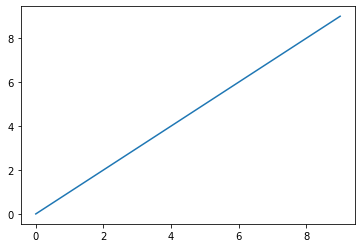

In [1]:
import matplotlib.pyplot as plt
plt.plot(range(10))
plt.show()

In [2]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [3]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv', parse_dates=['SALE DATE'], index_col='SALE DATE', )

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE
SALE DATE,,,,,,,,,,,,,,,,,,,,
2019-01-01,1,CHELSEA,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,NaN,R4,"447 WEST 18TH STREET, PH12A",PH12A,10011.0,1.0,0.0,1.0,"10,733",1979.0,2007.0,2,R4,0
2019-01-01,1,FASHION,21 OFFICE BUILDINGS,4,812,68,NaN,O5,144 WEST 37TH STREET,NaN,10018.0,0.0,6.0,6.0,"2,962",15435.0,1920.0,4,O5,0
2019-01-01,1,FASHION,21 OFFICE BUILDINGS,4,839,69,NaN,O5,40 WEST 38TH STREET,NaN,10018.0,0.0,7.0,7.0,"2,074",11332.0,1930.0,4,O5,0
2019-01-01,1,GREENWICH VILLAGE-WEST,13 CONDOS - ELEVATOR APARTMENTS,2,592,1041,NaN,R4,"1 SHERIDAN SQUARE, 8C",8C,10014.0,1.0,0.0,1.0,0,500.0,0.0,2,R4,0
2019-01-01,1,UPPER EAST SIDE (59-79),15 CONDOS - 2-10 UNIT RESIDENTIAL,2C,1379,1402,NaN,R1,"20 EAST 65TH STREET, B",B,10065.0,1.0,0.0,1.0,0,6406.0,0.0,2,R1,0


In [4]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [5]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

In [6]:
mask_building = df['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS'
df = df[mask_building]

mask_price = (df['SALE_PRICE'] < 2000000) & (df['SALE_PRICE'] > 100000)
df = df[mask_price]

df.select_dtypes('object').nunique()

df.drop(['ADDRESS', 'LAND_SQUARE_FEET', 'BUILDING_CLASS_AT_PRESENT', 'BUILDING_CLASS_AT_TIME_OF_SALE', 'EASE-MENT', 'APARTMENT_NUMBER'], inplace=True, axis=1)

df.select_dtypes('object').nunique()
df.isnull().value_counts().sum()
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,SALE_PRICE
SALE DATE,,,,,,,,,,,,,,
2019-01-01,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,11230.0,1.0,0.0,1.0,1325.0,1930.0,1,550000
2019-01-01,4,OTHER,01 ONE FAMILY DWELLINGS,1,7918,72,11427.0,1.0,0.0,1.0,2001.0,1940.0,1,200000
2019-01-02,2,OTHER,01 ONE FAMILY DWELLINGS,1,4210,19,10461.0,1.0,0.0,1.0,2043.0,1925.0,1,810000
2019-01-02,3,OTHER,01 ONE FAMILY DWELLINGS,1,5212,69,11226.0,1.0,0.0,1.0,2680.0,1899.0,1,125000
2019-01-02,3,OTHER,01 ONE FAMILY DWELLINGS,1,7930,121,11203.0,1.0,0.0,1.0,1872.0,1940.0,1,620000


In [7]:
y = df['SALE_PRICE']
X = df.drop('SALE_PRICE', axis=1)

mask_train = X.index.month < 4

X_train = X[mask_train]
y_train = y[mask_train]
X_test = X[~mask_train]
y_test = y[~mask_train]

print(X_train)
print(y_train)
print(X_test)
print(y_test)

           BOROUGH NEIGHBORHOOD  ... YEAR_BUILT TAX_CLASS_AT_TIME_OF_SALE
SALE DATE                        ...                                     
2019-01-01       3        OTHER  ...     1930.0                         1
2019-01-01       4        OTHER  ...     1940.0                         1
2019-01-02       2        OTHER  ...     1925.0                         1
2019-01-02       3        OTHER  ...     1899.0                         1
2019-01-02       3        OTHER  ...     1940.0                         1
...            ...          ...  ...        ...                       ...
2019-03-29       5        OTHER  ...     1950.0                         1
2019-03-29       5        OTHER  ...     1980.0                         1
2019-03-29       5        OTHER  ...     2018.0                         1
2019-03-29       5        OTHER  ...     1930.0                         1
2019-03-30       4        OTHER  ...     1950.0                         1

[2507 rows x 13 columns]
SALE DATE
20

In [8]:
from category_encoders import OneHotEncoder

ohe = OneHotEncoder(use_cat_names=True)
ohe.fit(X_train)

XT_train = ohe.transform(X_train)
XT_test = ohe.transform(X_test)

print(XT_train.head())
print(XT_test.head())

            BOROUGH_3  BOROUGH_4  ...  YEAR_BUILT  TAX_CLASS_AT_TIME_OF_SALE
SALE DATE                         ...                                       
2019-01-01          1          0  ...      1930.0                          1
2019-01-01          0          1  ...      1940.0                          1
2019-01-02          0          0  ...      1925.0                          1
2019-01-02          1          0  ...      1899.0                          1
2019-01-02          1          0  ...      1940.0                          1

[5 rows x 24 columns]
            BOROUGH_3  BOROUGH_4  ...  YEAR_BUILT  TAX_CLASS_AT_TIME_OF_SALE
SALE DATE                         ...                                       
2019-04-01          0          0  ...      1930.0                          1
2019-04-01          0          0  ...      1935.0                          1
2019-04-01          1          0  ...      1925.0                          1
2019-04-01          1          0  ...      1915.0    

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [9]:
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import Ridge, LinearRegression

kvalues = list(range(1, len(XT_train.columns), 2))
train_mae = []
test_mae = []

for i in kvalues:
   skb = SelectKBest(k=i)
   skb.fit(XT_train, y_train)
   XTT_train = skb.transform(XT_train)
   XTT_test = skb.transform(XT_test)

   l_model = LinearRegression()
   l_model.fit(XTT_train, y_train)

   train_mae.append(mean_absolute_error(y_train, l_model.predict(XTT_train)))
   test_mae.append(mean_absolute_error(y_test, l_model.predict(XTT_test)))



/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 4 12 23] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 4 12 23] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/l

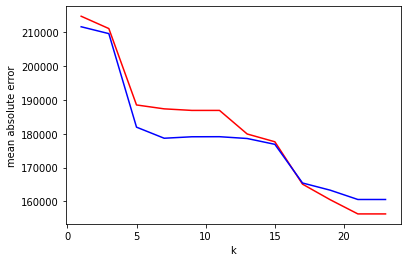

In [10]:
plt.plot(kvalues, train_mae, color='red', label='training')
plt.plot(kvalues, test_mae, color='blue', label='test')
plt.xlabel('k')
plt.ylabel('mean absolute error')
plt.show()
#print(kvalues)
#print(train_mae)

In [11]:
ridge_model = Ridge(alpha=21)
ridge_model.fit(XT_train, y_train)

Ridge(alpha=21, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [12]:
print('Training MAE:', mean_absolute_error(y_train, ridge_model.predict(XT_train)))
print('Test MAE:', mean_absolute_error(y_test, ridge_model.predict(XT_test)))
print('Training R Squared:', ridge_model.score(XT_train, y_train))
print('Test R Squared:', ridge_model.score(XT_test, y_test))

Training MAE: 160013.5724505357
Test MAE: 162247.44321894308
Training R Squared: 0.41543931252550337
Test R Squared: 0.36784982388178844
